**به نام خدا**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
R_earth = 6400 * 1000

In [3]:
gps_path = "gps.txt"
imu_path = "imu.txt"

## **read gps data** 

In [ ]:
gps_data = pd.read_csv(gps_path, names = ['timestamp', 'lat', 'lon'])

gps_data = gps_data.apply(pd.to_numeric, errors='coerce')

gps_data.dropna(inplace=True)

gps_data['lat_rad'] = gps_data['lat'] * np.pi / 180
gps_data['lon_rad'] = gps_data['lon'] * np.pi / 180

In [5]:
# get lan and lon initial
lat_0 = gps_data.iloc[0]["lat"] * np.pi / 180
lon_0 = gps_data.iloc[0]["lon"] * np.pi / 180

lat_0, lon_0

(0.8314659333524295, -2.131921775706176)

In [6]:
# get cordinate of gps 
gps_data['x'] = R_earth * (gps_data['lon_rad'] - lon_0) * np.cos(lat_0)
gps_data['y'] = R_earth * (gps_data['lat_rad'] - lat_0)

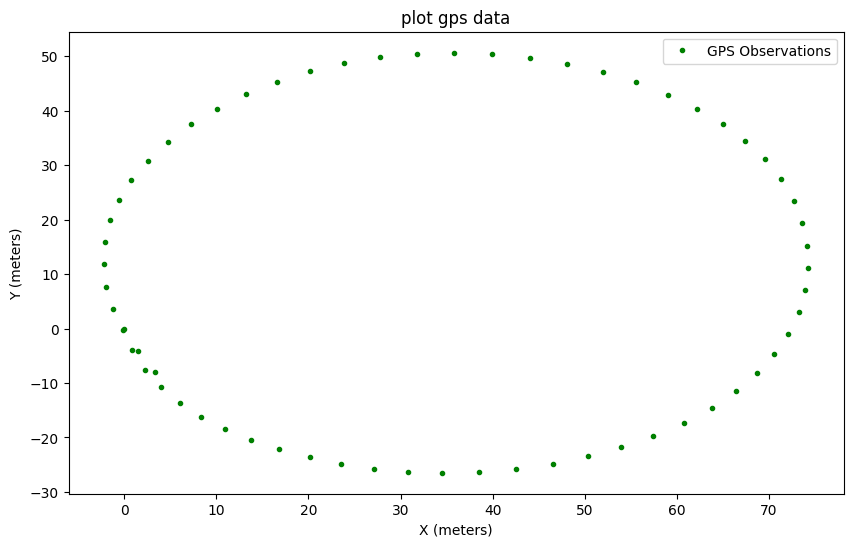

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(gps_data['x'], gps_data['y'], 'g.', label="GPS Observations")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.title("plot gps data")
plt.show()


## **read imu data**

In [8]:
imu_data = pd.read_csv(imu_path,
                       names = ['timestamp', 'ax', 'ay', "omega"])

imu_data = imu_data.apply(pd.to_numeric,
                           errors='coerce')

imu_data.dropna(inplace=True)
imu_data

,timestamp,ax,ay,omega
1,1.703098e+18,-4.220040,13.123875,0.580202
2,1.703098e+18,-4.483028,12.996460,0.560975
3,1.703098e+18,-4.188855,12.872254,0.555478
4,1.703098e+18,-3.938748,12.810721,0.551324
5,1.703098e+18,-3.802426,12.718110,0.551823
...,...,...,...,...
1346,1.703098e+18,-1.592860,10.903386,0.532668
1347,1.703098e+18,-1.533742,10.980806,0.533256
1348,1.703098e+18,-1.490765,10.902857,0.530932
1349,1.703098e+18,-1.428976,10.906902,0.532652


data

In [9]:
initial_state = np.array([
    gps_data['x'].iloc[0],
    gps_data['y'].iloc[0],
    0, 
    0, 
    0
])

initial_state

array([0., 0., 0., 0., 0.])

In [10]:
R = np.diag([100, 100, 16, 16, 0.25])  # Process noise
Q = np.diag([100, 100])  # Observation noise

In [11]:
X_est = initial_state
P = np.eye(5) * 100

In [12]:
def state_transition(X_prev, ax, ay, omega, dt):
    ax = ax * np.cos(omega) - ay * np.sin(omega)
    ay = ax * np.sin(omega) + ay * np.cos(omega)
    
    x, y, vx, vy, psi = X_prev
    x += vx * dt + 0.5 * ax * dt**2
    y += vy * dt + 0.5 * ay * dt**2
    vx += ax * dt
    vy += ay * dt
    psi += omega * dt
    return np.array([x, y, vx, vy, psi])

In [13]:
def jacobian_F(X, ax, ay, omega_z, dt):
    F = np.eye(5)
    F[0, 2] = F[1, 3] = dt
    F[0, 4] = F[2, 4] = - ((ax * np.sin(omega_z)) + (ay * np.cos(omega_z)))
    F[1, 4] = F[3, 4] = (ax * np.cos(omega_z)) - (ay * np.sin(omega_z))
    return F

In [18]:
x_prev = np.array([10, 15, 2, 3, np.pi / 4]) 
ax = 0.5       
ay = 0.3        
omega_z = 0.1   
dt = 0.1       

j = jacobian_F(x_prev, ax, ay, omega_z, dt)

In [19]:
j

array([[ 1.        ,  0.        ,  0.1       ,  0.        , -0.34841796],
       [ 0.        ,  1.        ,  0.        ,  0.1       ,  0.46755206],
       [ 0.        ,  0.        ,  1.        ,  0.        , -0.34841796],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.46755206],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ]])

In [14]:
estimates = []  

In [ ]:
R = np.diag([100, 100, 16, 16, 0.25])  # Process noise
Q = np.diag([100, 100])  # Observation noise

X_est = initial_state
prob = [50,50,3,3,1]
P = np.eye(5) * prob 

estimates = []
gps_index = 0

In [16]:
estimates = []
gps_index = 0
eclips = []

In [17]:
def observation_model(X):
    return X[:2] 

In [20]:
for i, imu_row in imu_data.iterrows():
    dt = (imu_row['timestamp'] - imu_data['timestamp'].iloc[i - 1]) * 1e-9 if i > 0 else 0
    ax, ay, omega_z = imu_row['ax'], imu_row['ay'], imu_row['omega']

    X_pred = state_transition(X_est, ax, ay, omega_z, dt)
    F = jacobian_F(X_est, ax, ay, omega_z, dt)
    P = F @ P @ F.T + R

    eclips.append([np.sqrt(P[0][0]),np.sqrt(P[0][1])])

    if gps_index < len(gps_data) and gps_data['timestamp'].iloc[gps_index] <= imu_row['timestamp']:
        z = np.array([gps_data['x'].iloc[gps_index], gps_data['y'].iloc[gps_index]])
        H = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0]])
        S = H @ P @ H.T + Q
        K = P @ H.T @ np.linalg.inv(S)
        X_est = X_pred + K @ (z - observation_model(X_pred))
        P = (np.eye(5) - K @ H) @ P
        gps_index += 1
    else:
        X_est = X_pred

    estimates.append(X_est)

estimates = np.array(estimates)

In [34]:
# eclips

In [22]:
estimates[0]

array([0., 0., 0., 0., 0.])

In [23]:
x = estimates[:, 0]
y = estimates[:, 1]

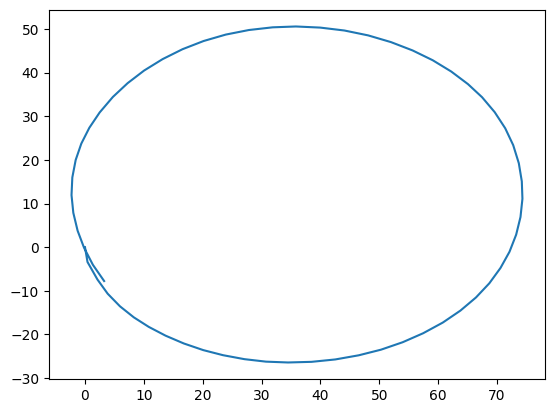

In [24]:
plt.plot(x,y)

In [26]:
x = estimates.T
x[:2]

array([[ 0.        ,  0.        ,  0.        , ...,  3.2533708 ,
         3.2533708 ,  3.2533708 ],
       [ 0.        ,  0.        ,  0.        , ..., -7.76428471,
        -7.76428471, -7.76428471]])

In [28]:
eclips[0]

[15.00145982549411, 9.638382066165477]

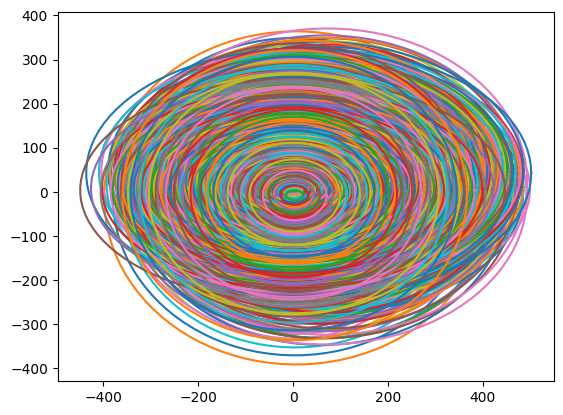

In [29]:
for i in range(1350):
    x = estimates[:, 0][i]
    y = estimates[:, 1][i]

    a = eclips[i][0]
    b = eclips[i][1]

    t = np.linspace(0, 2*np.pi,100)
    plt.plot(x+a*np.cos(t), y+b*np.sin(t))


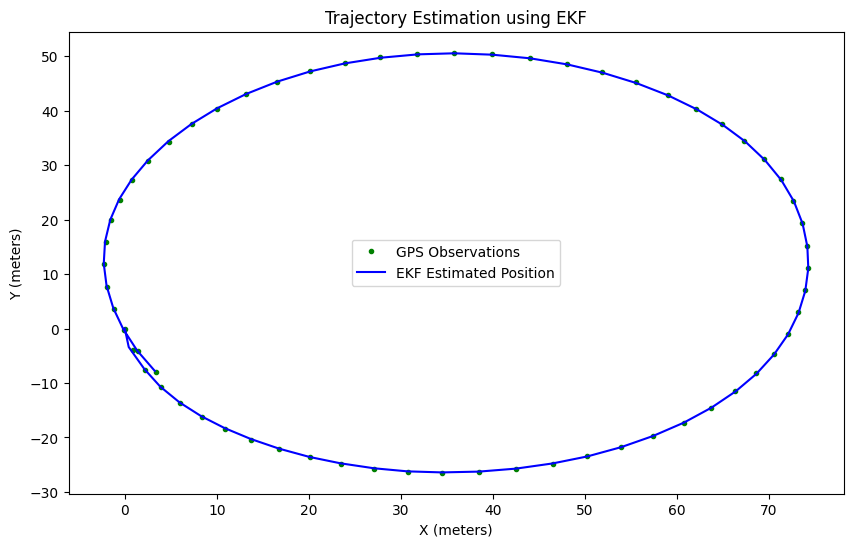

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(gps_data['x'], gps_data['y'], 'g.', label="GPS Observations")
plt.plot(estimates[:, 0], estimates[:, 1], 'b-', label="EKF Estimated Position")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.title("Trajectory Estimation using EKF")
plt.show()


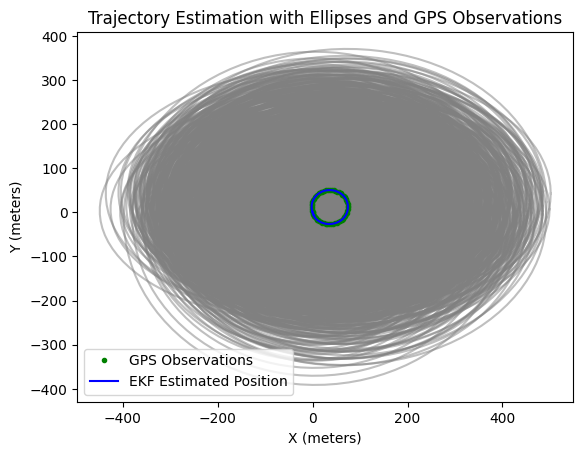

In [31]:
for i in range(1350):
    x = estimates[:, 0][i]
    y = estimates[:, 1][i]

    a = eclips[i][0]
    b = eclips[i][1]

    t = np.linspace(0, 2 * np.pi, 100)
    plt.plot(x + a * np.cos(t), y + b * np.sin(t), color='gray', alpha=0.5)

plt.plot(gps_data['x'], gps_data['y'], 'g.', label="GPS Observations")
plt.plot(estimates[:, 0], estimates[:, 1], 'b-', label="EKF Estimated Position")


plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.title("Trajectory Estimation with Ellipses and GPS Observations")
plt.show()


In [32]:
Q = np.diag([200, 200])

In [33]:
X_est = initial_state
prob = [50,50,3,3,1]
P = np.eye(5) * prob 

estimates = []

In [35]:
for i, imu_row in imu_data.iterrows():
    dt = (imu_row['timestamp'] - imu_data['timestamp'].iloc[i - 1]) * 1e-9 if i > 0 else 0
    ax, ay, omega_z = imu_row['ax'], imu_row['ay'], imu_row['omega']

    X_pred = state_transition(X_est, ax, ay, omega_z, dt)
    F = jacobian_F(X_est, ax, ay, omega_z, dt)
    P = F @ P @ F.T + R

    eclips.append([np.sqrt(P[0][0]),np.sqrt(P[0][1])])

    if gps_index < len(gps_data) and gps_data['timestamp'].iloc[gps_index] <= imu_row['timestamp']:
        z = np.array([gps_data['x'].iloc[gps_index], gps_data['y'].iloc[gps_index]])
        H = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0]])
        S = H @ P @ H.T + Q
        K = P @ H.T @ np.linalg.inv(S)
        X_est = X_pred + K @ (z - observation_model(X_pred))
        P = (np.eye(5) - K @ H) @ P
        gps_index += 1
    else:
        X_est = X_pred

    estimates.append(X_est)

estimates = np.array(estimates)

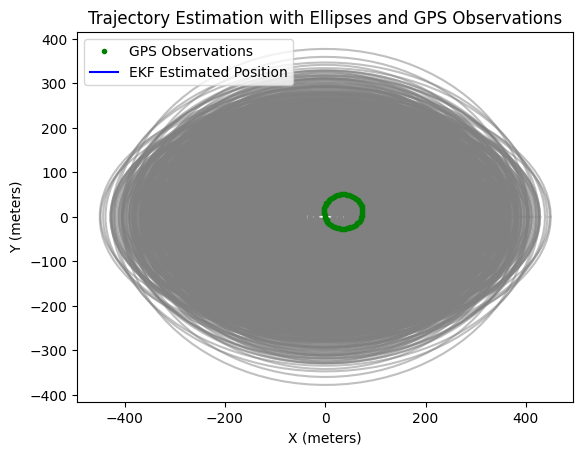

In [36]:
for i in range(1350):
    x = estimates[:, 0][i]
    y = estimates[:, 1][i]

    a = eclips[i][0]
    b = eclips[i][1]

    t = np.linspace(0, 2 * np.pi, 100)
    plt.plot(x + a * np.cos(t), y + b * np.sin(t), color='gray', alpha=0.5)

plt.plot(gps_data['x'], gps_data['y'], 'g.', label="GPS Observations")
plt.plot(estimates[:, 0], estimates[:, 1], 'b-', label="EKF Estimated Position")


plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.title("Trajectory Estimation with Ellipses and GPS Observations")
plt.show()